# Recomendador de revistas científicas para enviar una publicación
### Por Iru Nervey Navarro Alejo

El objetivo de esta tarea es automatizar la selección de revista a la que enviar un artículo para su publicación.

Para esta tarea se ha desarrollado un recomendador el cual ha sido entrenado con artículos de cuatro revistas, de forma que puede identificar que revista es la más adecuada de estas cuatro para nuestro artículo.

## Datos utilizados
Se han seleccionados los artículos de los años 2018, 2019, 2020 y 2021 de las revistas Data & Knowledge Engineering, Expert Systems with Applications,Journal of Visual Communication and Image Representation, Pattern Recognition 

## Desarrollo del recomendador
### Preparación del entorno
Para el desarrollo del recomendador comenzamos preparando el entorno. Nos conectamos al drive y extraemos los datos necesarios de los artículos.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Carpeta donde se encuentran las revistas

In [ ]:
carpeta='/content/drive/MyDrive/CDI/trabajo/'
rev2=carpeta+'Revista2/'
rev3=carpeta+'Revista3/'
rev4=carpeta+'Revista4/'
rev6=carpeta+'Revista6/'

In [ ]:
pip install bibtexparser


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import bibtexparser
import os
import string
import nltk


def leerCarpeta(carpeta,df,revista):
  archivos = os.listdir(carpeta)
  for archivo in archivos:
    with open(os.path.join(carpeta,archivo), 'r') as bibtex_file:
      bibtex_str = bibtex_file.read()
    bib_database = bibtexparser.loads(bibtex_str)
    entries = [{'abstract': entry['abstract'], 'title': entry['title'], 'magazine': revista} for entry in bib_database.entries if 'abstract' in entry]
    df=df.append(entries,ignore_index=True)
  return df


In [ ]:
dfCompleto=pd.DataFrame()
dfCompleto=dfCompleto.assign(abstract=None,title=None,magazine=None)
dfCompleto=leerCarpeta(rev2,dfCompleto,0)
dfCompleto=leerCarpeta(rev3,dfCompleto,1)
dfCompleto=leerCarpeta(rev4,dfCompleto,2)
dfCompleto=leerCarpeta(rev6,dfCompleto,3)
for i in range(0,4):
  print('El número de artículos en la revista {} son {:4d} siendo un {:2.2f}% del total de artículos'.format(i,len(dfCompleto['abstract'][dfCompleto['magazine']==i]),len(dfCompleto['abstract'][dfCompleto['magazine']==i])/len(dfCompleto)*100))


El número de artículos en la revista 0 son  185 siendo un 3.47% del total de artículos
El número de artículos en la revista 1 son 3543 siendo un 66.49% del total de artículos
El número de artículos en la revista 2 son  940 siendo un 17.64% del total de artículos
El número de artículos en la revista 3 son  661 siendo un 12.40% del total de artículos


El primer problema con el que nos enfrentamos es que los artículos se encuentran desbalanceados. Podemos intuir que el recomendador tendra problemas para clasificar los artículos de la revista 0 (revista 2) por la cantidad tan reducida de articulos que contiene.

A continuación se eliminaran las stopwords ya que no presentan información relevante del artículo y pondra todas letras en minusculas.

In [ ]:

dfMod=dfCompleto.copy()
dfMod['abstract'] = dfMod['abstract'].str.lower()
dfMod['abstract'] = dfMod['abstract'].apply(lambda x: x.translate(str.maketrans('','',string.punctuation)))

nltk.download('stopwords')
nltk.download('punkt')
stopwords = nltk.corpus.stopwords.words('english')
dfMod['abstract'] = dfMod['abstract'].apply(lambda x: (' ').join([word for word in nltk.word_tokenize(x) if word not in (stopwords)]))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Desarrollo del modelo
Una vez hemos preparado los artículos procedemos a desarrollar el modelo.

In [ ]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Activation
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from typing_extensions import ParamSpecArgs

Dividimos los 'abstract' por palabras y separamos los artículos en dos conjuntos, el conjunto de test y el conjunto de entrenamiento.

In [ ]:
bowTF = CountVectorizer()
doc_term_TF = bowTF.fit_transform(dfMod['abstract'])

bowTFIDF = TfidfVectorizer()
doc_term_TFIDF = bowTFIDF.fit_transform(dfMod['abstract'])

df_train, df_test = train_test_split(dfMod, test_size=0.3, shuffle=True,random_state=27)

x_train = df_train['abstract']
x_test = df_test['abstract']

y_train = df_train['magazine'].values
y_test = df_test['magazine'].values

encode = OneHotEncoder()

y_train = encode.fit_transform(y_train.reshape(-1,1))
y_test = encode.fit_transform(y_test.reshape(-1,1))

y_train = y_train.toarray()
y_test = y_test.toarray()

num_palabras=1000
long_secuencia=200
tokenizer = Tokenizer(num_words=num_palabras)
tokenizer.fit_on_texts(x_train)

Ahora procedemos a entrenar el modelo

In [ ]:
secuencia = tokenizer.texts_to_sequences(x_train)
secuencia_train = sequence.pad_sequences(secuencia, maxlen=long_secuencia)

secuencia = tokenizer.texts_to_sequences(x_test)
secuencia_test = sequence.pad_sequences(secuencia, maxlen=long_secuencia)

Se han desarrollado tres modelos RNN para comparar resultados posteriormente. Estas redes neuronales recurrentes contienen una capa de neuronas LSTM que nos permiten recordar información de los pasos anteriores, resultando especiamente utililes a la hora de trabajar con el lenguaje natural.

In [ ]:
def RNN(tam_entrada, num_palabras, num_classes):
  input = Input(name='inputs', shape=[tam_entrada])
  layer = Embedding(num_palabras,20,input_length=tam_entrada)(input)
  layer = LSTM(50)(layer)
  layer = Dense(256, name ='FC1')(layer)
  layer = Activation('relu')(layer)
  layer = Dropout(0.5)(layer)
  layer = Dense(num_classes,name='output_layer')(layer)
  output = Activation('softmax')(layer)
  model = Model(inputs=input,outputs=output)
  return model

def RNN1(tam_entrada, num_palabras, num_classes):
  input = Input(name='inputs', shape=[tam_entrada])
  layer = Embedding(num_palabras,20,input_length=tam_entrada)(input)
  layer = LSTM(100)(layer)
  layer = Dense(256, name ='FC1')(layer)
  layer = Activation('relu')(layer)
  layer = Dropout(0.5)(layer)
  layer = Dense(num_classes,name='output_layer')(layer)
  output = Activation('softmax')(layer)
  model = Model(inputs=input,outputs=output)
  return model

def RNN2(tam_entrada, num_palabras, num_classes):
  input = Input(name='inputs', shape=[tam_entrada])
  layer = Embedding(num_palabras,20,input_length=tam_entrada)(input)
  layer = LSTM(100)(layer)
  layer = Dense(512, name ='FC1')(layer)
  layer = Activation('relu')(layer)
  layer = Dropout(0.5)(layer)
  layer = Dense(num_classes,name='output_layer')(layer)
  output = Activation('softmax')(layer)
  model = Model(inputs=input,outputs=output)
  return model

def entrenar(modelo):
  modelo.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])
  modelo.fit(secuencia_train, y_train,batch_size=64, epochs=num_epocas, validation_split=0.3, callbacks=callback)
  return modelo.evaluate(secuencia_test, y_test)[1]

Entrenamos los tres modelos vemos los resultados obtenidos

In [ ]:
modelo = RNN(long_secuencia, num_palabras, 4)
modelo.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])

modelo1 = RNN1(long_secuencia, num_palabras, 4)
modelo1.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])

modelo2 = RNN2(long_secuencia, num_palabras, 4)
modelo2.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])


callback = EarlyStopping(monitor='val_loss',patience=5)
num_epocas = 20
modelo.fit(secuencia_train, y_train,batch_size=64, epochs=num_epocas, validation_split=0.3, callbacks=callback)
modelo1.fit(secuencia_train, y_train,batch_size=64, epochs=num_epocas, validation_split=0.3, callbacks=callback)
modelo2.fit(secuencia_train, y_train,batch_size=64, epochs=num_epocas, validation_split=0.3, callbacks=callback)



Epoch 1/20
41/41 [==============================] - 11s 188ms/step - loss: 1.1261 - accuracy: 0.6503 - val_loss: 0.9179 - val_accuracy: 0.6738
Epoch 2/20
41/41 [==============================] - 6s 153ms/step - loss: 0.8813 - accuracy: 0.6645 - val_loss: 0.7728 - val_accuracy: 0.6792
Epoch 3/20
41/41 [==============================] - 6s 150ms/step - loss: 0.6659 - accuracy: 0.7331 - val_loss: 0.6519 - val_accuracy: 0.7364
Epoch 4/20
41/41 [==============================] - 6s 150ms/step - loss: 0.5388 - accuracy: 0.7836 - val_loss: 0.6461 - val_accuracy: 0.7614
Epoch 5/20
41/41 [==============================] - 7s 175ms/step - loss: 0.4727 - accuracy: 0.8231 - val_loss: 0.6739 - val_accuracy: 0.7694
Epoch 6/20
41/41 [==============================] - 10s 247ms/step - loss: 0.4208 - accuracy: 0.8514 - val_loss: 0.6614 - val_accuracy: 0.7676
Epoch 7/20
41/41 [==============================] - 8s 193ms/step - loss: 0.3826 - accuracy: 0.8690 - val_loss: 0.7411 - val_accuracy: 0.7775
Epoc

KeyboardInterrupt: ignored

Para poder comparar los modelos es necesario relalizar el entrenamiento varias veces y hacer algun ajuste estadístico, en este caso se ha ejecutado cada modelo 10 veces y se ha realizado la media para comparar los resultados obtenidos.

In [ ]:
comparar=False
#comparar=True #descomentar para comparar los modelos

if comparar:
  num_entre=10
  res_test =0
  for i in range(0,num_entre):
    res_test += entrenar(RNN(long_secuencia, num_palabras, 4))

  res_test1 =0
  for i in range(0,num_entre):
    res_test1 += entrenar(RNN1(long_secuencia, num_palabras, 4))

  res_test2 =0
  for i in range(0,num_entre):
    res_test2 += entrenar(RNN2(long_secuencia, num_palabras, 4))

  print('Accuracy: {:.2f}'.format(res_test/num_entre))
  print('Accuracy: {:.2f}'.format(res_test1/num_entre))
  print('Accuracy: {:.2f}'.format(res_test2/num_entre))

### Resultados


Se puede observar que como se mencionó anteriormente el modelo no es capaz de realizar la clasificación correctamente en la revista 0 (revista 2). Para mejorar estos resultados se podria tratar de balancear los datos o ajustar el modelo de forma que le de mayor importancia a los errores poducidos en esta clasificación. 
Yo optaria por aumentar la cantidad de artículos ya que se esta trabajando con una cantidad de artículos muy escasa para trabajar con machine learning.

Salvo por los errores producidos en la revista etiquetada como 0 los tres modelos funcionan bastante bien, teniendo una presición del 80% aproximadamente.
A continuacion se ve una matriz de confusión en la que se ve claramente que el etiquetado de la revista 0 es un problema grave, ya que no es capaz de clasificar ninguno de sus articulos correctamente.

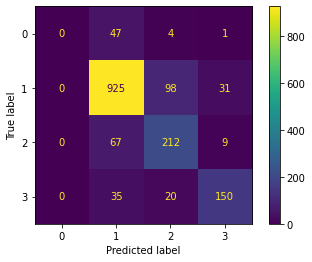

50/50 [==============================] - 3s 44ms/step


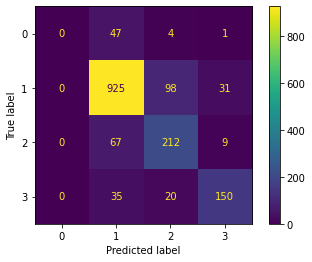

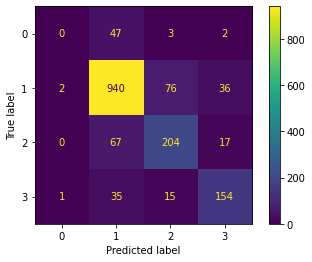

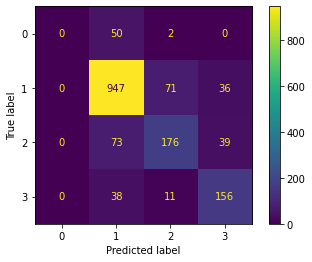

In [ ]:
y_pred = modelo.predict(secuencia_test)
y_pred = np.argmax(y_pred, axis=1)

y_pred1 = modelo1.predict(secuencia_test)
y_pred1 = np.argmax(y_pred1, axis=1)

y_pred2 = modelo2.predict(secuencia_test)
y_pred2 = np.argmax(y_pred2, axis=1)

cm =confusion_matrix(list(np.transpose(encode.inverse_transform(y_test))[0]), list(y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

cm1 =confusion_matrix(list(np.transpose(encode.inverse_transform(y_test))[0]), list(y_pred1))
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp1.plot()

cm2 =confusion_matrix(list(np.transpose(encode.inverse_transform(y_test))[0]), list(y_pred2))
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2)
disp2.plot()

Adicionalmente se ha desarrollado un clasificador que hace uso de ramdom forest con el que no se han conseguido buenos resultados

Accuracy: 0.64


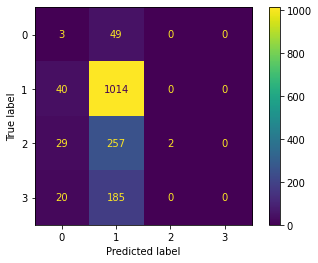

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier(class_weight ='balanced',n_estimators=5000,n_jobs=-1)
clf = clf.fit(secuencia_train, y_train)

res_test =clf.score(secuencia_test, y_test)

print('Accuracy: {:.2f}'.format(res_test))

y_pred = clf.predict(secuencia_test)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(list(np.transpose(encode.inverse_transform(y_test))[0]), list(y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()